### Trabalho Prático II da Disciplina Aprendizado Profundo para Processamento de Linguagem Natural

Professor: Adriano Veloso

Aluna: Antonio Carlos da Anunciação

Matrícula: 2018019443

---

Este trabalho visa desenvolver um modelo de POS TAGGING para desse modo fazer classificação gramatical das palavras em português.

Dataset: **Mac-Morpho**

---

Bibliotecas utilizadas:

In [1]:
import os
import sys
import tarfile
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import random 
import urllib.request
import tarfile

from nltk import tokenize 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Antonio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Download e preparação dos arquivos de treino:

In [2]:
if not os.path.exists('macmorpho-v3.tgz'):
    url = 'http://nilc.icmc.usp.br/macmorpho'
    filename = 'macmorpho-v3.tgz'
    urllib.request.urlretrieve(url, filename)
    tar = tarfile.open(filename)
    tar.extractall()
    tar.close()


In [3]:
def read_txt(name_arq):
    with open(name_arq, encoding='utf-8') as fp:
        arq = []
        while True:
            line = fp.readline()
            arq.append(line.strip())
            if not line:
                break
    return arq

#### Sobre o dataset Macmorpho:
Mac-Morpho é um corpus de textos em português brasileiro anotados com tags de classes gramaticais. Sua primeira versão foi lançada em 2003 e, desde então, duas revisões foram feitas com o objetivo de melhorar a qualidade do recurso.

O corpus está disponível para download dividido em seções de treinamento, desenvolvimento e teste. Estes são 76%, 4% e 20% do corpus total, respectivamente (a razão para os números incomuns é que o corpus foi primeiro dividido em 80% / 20% trem / teste e, em seguida, 5% da seção do trem foi definida à parte para desenvolvimento).

Exemplo de pos-tagging para verbo e artigo:


**ARTIGO (ART)**
É a classe de palavras que morfologicamente variam em gênero e número e são sempre pré -nominais, determinando o sintagma nominal de forma determinada ou indeterminada.
 <blockquote>
  <p>
    O_ART patinho feio vivia chorando.<br />
    No meio do caminho havia uma_ART pedra.<br />
    Era uma_ART grande amiga.<br />      
    As_ART folhas secas caíam no outono.<br />       
    Os_ART alunos chegaram cedo.<br />      
    Tinha uns_ART repentes interessantes.<br />
    Era um_ART homem de sorte.<br />
  </p>
</blockquote>


**VERBO (V)**
A classe dos verbos é composta por palavras que se flexionam em número, pessoa, modo, tempo, aspecto e voz e desempenham sempre o papel de núcleo em um predicado. De acordo com a MiniGramática (NILC), “é a palavra que expressa processos, ação,
estado, mudança de estado, fenômeno da natureza, conveniência, desejo e existência”.

 <blockquote>
  <p>
    Eu moro_V em São Carlos.<br />
    O nome dele é_V Luís.<br />
    Fomos_V pra praia e nos divertimos_V muito.<br />
    Desça_V daí, menino!<br />
    Choveu_V.<br />
    Há_V muito tempo que ele não vem_V aqui.<br />
    Andava_V triste pelos cantos.<br />
    Gostaria_V de uma cerveja.<br />
    Será_V que vai chover_V?<br />
    O que será_V de mim?<br />
    Caiu_V no buraco.<br />
    Só iria_V se eu fosse_V.<br />
    Estava_VAUX estudando_V muito para os exames.<br />
  </p>
</blockquote>

Lendo os dados de treino e teste:

In [4]:
macmorpho_test = read_txt("macmorpho-test.txt")
macmorpho_train = read_txt("macmorpho-train.txt")

Como mostrado nos exemplos sobre o dataset Macmorpho as palavras são separadas de sua respectiva TAG com um "_" seguido da classe gramatical da palavra, então podemos separar-las com base nesse tag de separação "_":

In [5]:
def tagged_sentences(sentence):
    lista = sentence.split()
    tag_sent = [(str.partition(word, '_')[0], str.partition(word, '_')[2]) for word in lista]
    return tag_sent

In [6]:
train_sentences = list(map(tagged_sentences, macmorpho_train)) 
test_sentences = list(map(tagged_sentences, macmorpho_test)) 

Formatação das estruturas das sentenças:

In [7]:
def features(sentence, index):
    return {
    'word': sentence[index],
    'is_first': index == 0,
    'is_last': index == len(sentence) - 1,
    'is_capitalized': sentence[index][0].upper() == sentence[index][0],
    'is_all_caps': sentence[index].upper() == sentence[index],
    'is_all_lower': sentence[index].lower() == sentence[index],
    'prefix-1': sentence[index][0],
    'prefix-2': sentence[index][:2],
    'prefix-3': sentence[index][:3],
    'suffix-1': sentence[index][-1],
    'suffix-2': sentence[index][-2:],
    'suffix-3': sentence[index][-3:],
    'prev_word': '' if index == 0 else sentence[index - 1],
    'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
    'has_hyphen': '-' in sentence[index],
    'is_numeric': sentence[index].isdigit(),
    'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [8]:
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

In [9]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
    return X, y

Separação do dataset:

In [10]:
X_train, y_train = transform_to_dataset(train_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

In [27]:
 sys.getsizeof(X_train[0])

648

Modelo de decisão para treino:

In [11]:
model = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='entropy')) ])

In [30]:
# Valor baseado no limite de memoria disponivel
array_size = 25000

In [13]:
model.fit(X_train[:array_size],y_train[:array_size]) 

Pipeline(steps=[('vectorizer', DictVectorizer(sparse=False)),
                ('classifier', DecisionTreeClassifier(criterion='entropy'))])

In [14]:
pred = list(model.predict(X_test[:array_size]))

In [15]:
print ("Acurácia: {:.2%}".format(model.score(X_test[:array_size], y_test[:array_size])))

Acurácia: 84.10%


In [16]:
labels = np.unique(y_test[:array_size])
cf_matrix = confusion_matrix(y_test[:array_size], pred, labels=labels)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in labels],columns = [i for i in labels])

In [17]:
acc_pos_tag = pd.DataFrame(labels, columns=['label'])
acc_pos_tag['porcentagem_acertos'] = None

In [18]:
for i,x in acc_pos_tag.iterrows():
    label = acc_pos_tag['label'][i]
    acc_pos_tag['porcentagem_acertos'][i] = (df_cm[label][label]/df_cm[label].sum(skipna = True))*100
    
acc_pos_tag = acc_pos_tag.fillna(0)

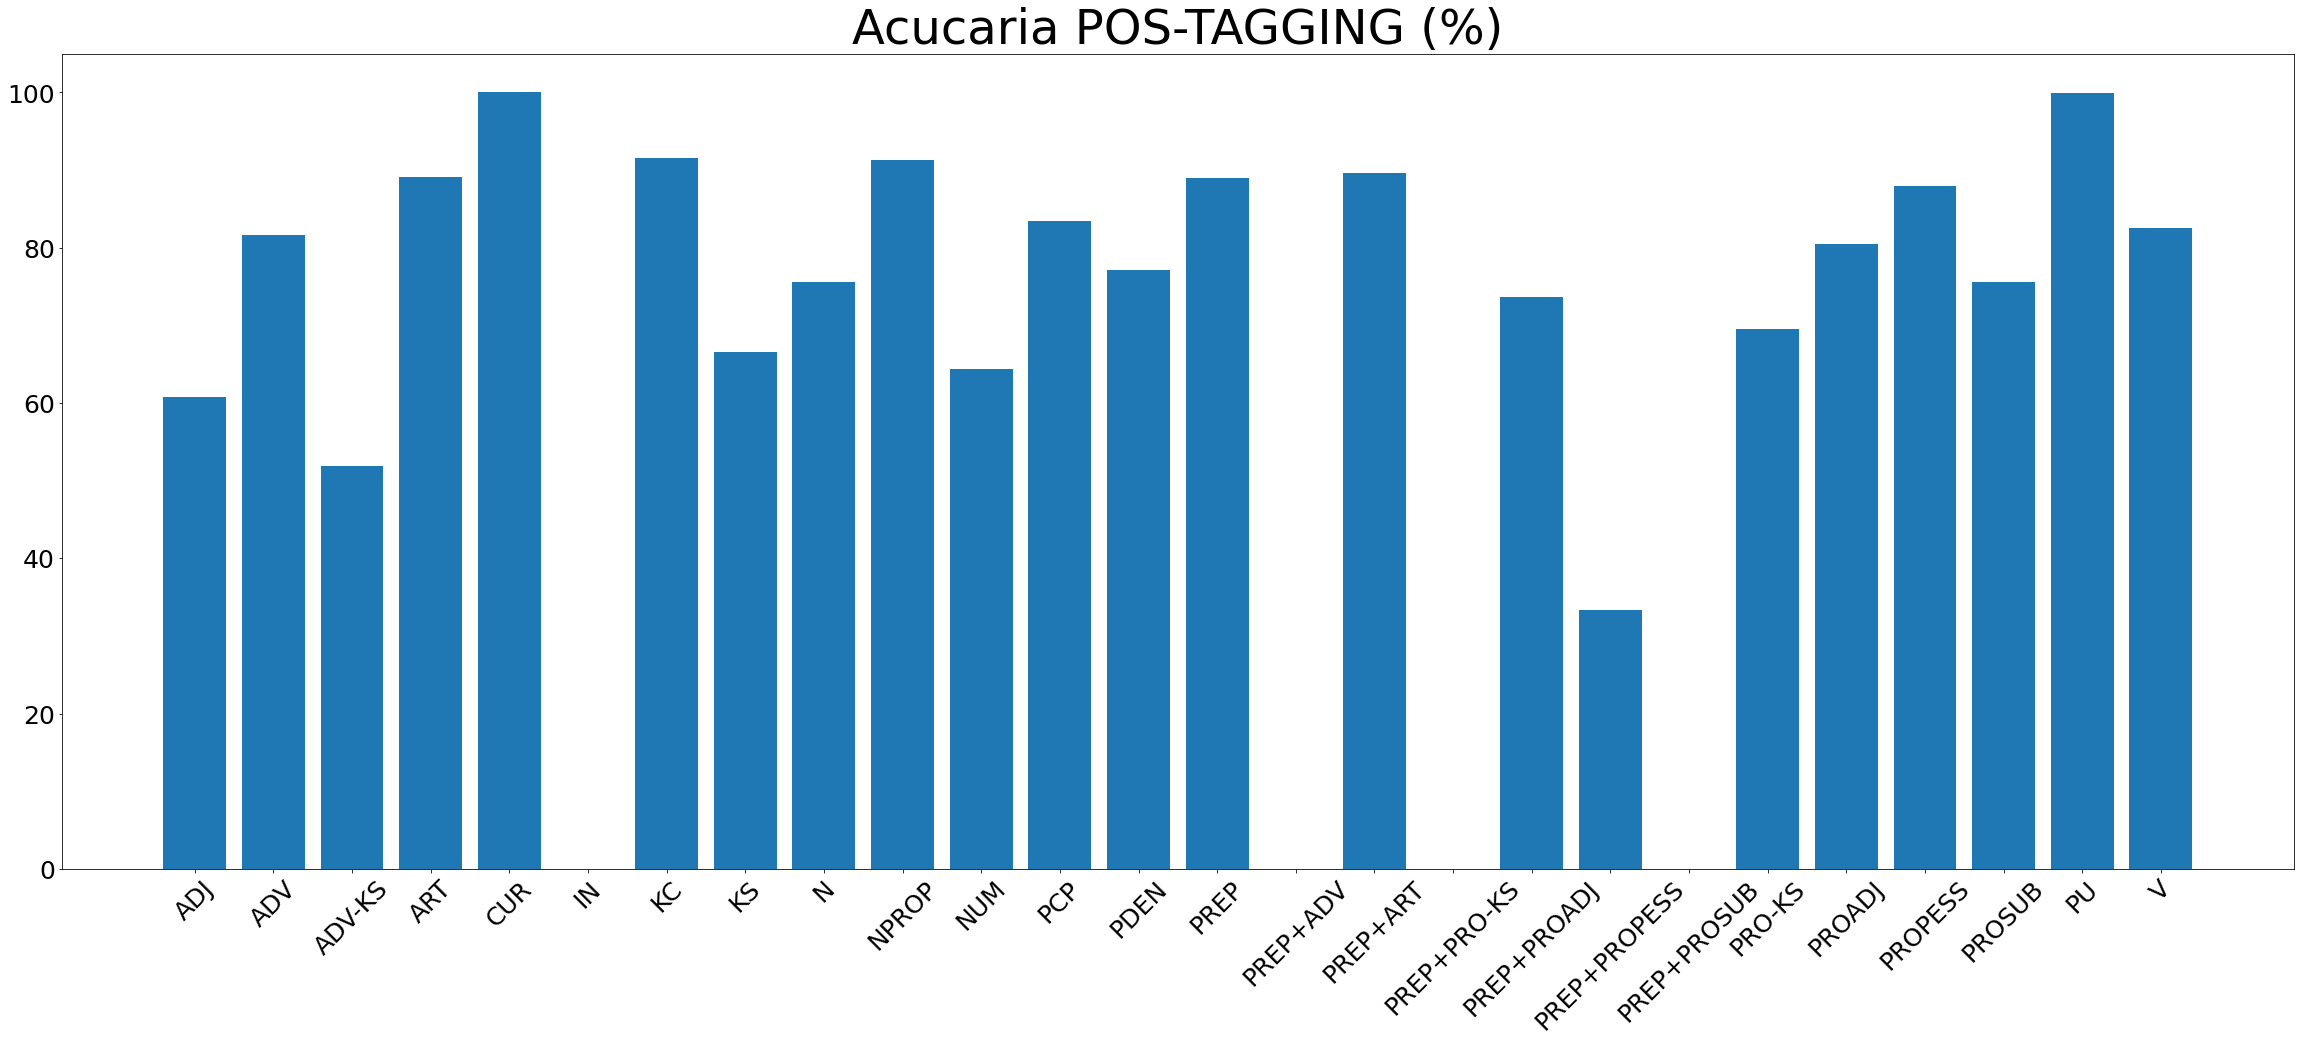

In [22]:
plt.rcParams.update({'font.size': 40})
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.figure(figsize = (40,15))
plt.bar(acc_pos_tag['label'],acc_pos_tag['porcentagem_acertos'])
plt.xticks(rotation=45)
plt.title("Acucaria POS-TAGGING (%)")
plt.show()

---
#### Testando o Modelo:

In [20]:
def pos_tag(sentence):
    tagged_sentence = []
    tags = model.predict([features(sentence, index) for index in range(len(sentence))])
    return zip(sentence, tags)

In [31]:
# Entre com um arquivo de texto qualquer, em portugues:

try:
    poema = open('NoMeioDoCaminho.txt', 'r')
except:
    url = 'https://drive.google.com/file/d/1fA4svZSqivOOU43jMotBd8adaqQlQzKV/view?usp=sharing'
    filename = 'NoMeioDoCaminho.txt'
    urllib.request.urlretrieve(url, filename)
    poema = open('NoMeioDoCaminho.txt', 'r')
    
Lines = poema.readlines()
for line in Lines:
    palavras_tokenize = tokenize.word_tokenize(line, language='portuguese') 
    POS_list = list(pos_tag(palavras_tokenize))
    for t in POS_list:
        print(u"{:<16}{:>2}".format(str(t[0]),str(t[1])))
    print("------------------\n")

Drummond        NPROP
de              PREP
Andrade         NPROP
------------------

No              PREP+ART
meio             N
do              PREP+ART
caminho          N
tinha            V
uma             ART
pedra            N
------------------

Tinha            V
uma             ART
pedra            N
no              PREP+ART
meio             N
do              PREP+ART
caminho          N
------------------

Tinha            V
uma             ART
pedra            N
------------------

No              PREP+ART
meio             N
do              PREP+ART
caminho          N
tinha            V
uma             ART
pedra            N
------------------

Nunca           PREP+ART
me               N
esquecerei       V
desse            N
acontecimento    N
------------------

Na              PREP+ART
vida             N
de              PREP
minhas           N
retinas          N
tÃ£o             N
fatigadas       PCP
------------------

Nunca           PREP+ART
me               N
esquecerei  

---
### Discussão dos resultados:

<p>
<div style="text-align: justify"> A primeira caracteristicas a ser notada é a influencia do tamanho do vetor de treino na acurácia, quanto maior, melhores os resultados, em pequenos exemplos como a aplicação da função de teste "pos_tag" acima, nos da um exemplo de como o classificar de POS-TAGGING erra. No exemplo do texto acima foram usadas 25mil sentenças no treino. Porem se esse número for menor que 10mil sentenças o modelo começa a errar significativamente em tarefas criticas, como na identificação de nomes proprios(o sobrenome especificamente), ele entende que o sobrenome, quando vem precedido de uma preposição, não é um nome proprio. </div>
</p><p>
<div style="text-align: justify"> Outro fato determinante na qualidade das classificações são as quantidades das palavras que representam determinadas classes gramaticais dentro do nosso conjunto de dados, assim um conjunto homogeneo e com classes representativamentes equilibradas terão um resultado melhor. </div></p>


---
### Referencias:
    [1] - http://www.nltk.org/howto/portuguese_en.html
    [2] - https://github.com/gesteves91/nlp/blob/master/notebooks/12-pos-tagging.ipynb